<a href="https://colab.research.google.com/github/jjyjung/ai/blob/gh-pages/tf_keras_CNN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Google Drive 연결

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')   # google drive를 google colab에 연결. 처음 실행 시, 인증 필요 

Mounted at /content/gdrive


Google Drive 파일 읽기 테스트

In [ ]:
import pandas as pd

# BMI 데이터를 읽어 들이고 정규화하기
dir = "/content/gdrive/My Drive/Colab Notebooks/ai/"
df = pd.read_csv(dir + "bmi.csv")
df

,height,weight,label
0,142,62,fat
1,142,73,fat
2,177,61,normal
3,187,48,thin
4,153,60,fat
...,...,...,...
19995,122,58,fat
19996,193,69,normal
19997,193,37,thin
19998,195,51,thin


CIFAR-10 데이터 불러오기

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import time

# CIFAR-10 데이터셋을 읽고 신경망에 입력할 형태로 변환
(x_train,y_train),(x_test,y_test)=cifar10.load_data()
x_train=x_train.astype(np.float32)/255.0
x_test=x_test.astype(np.float32)/255.0
y_train=tf.keras.utils.to_categorical(y_train,10)
y_test=tf.keras.utils.to_categorical(y_test,10)

170508288/170498071 [==============================] - 11s 0us/step


CNN 모델 설계 및 가시화

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 10, 10, 64)        36928     
                                                      

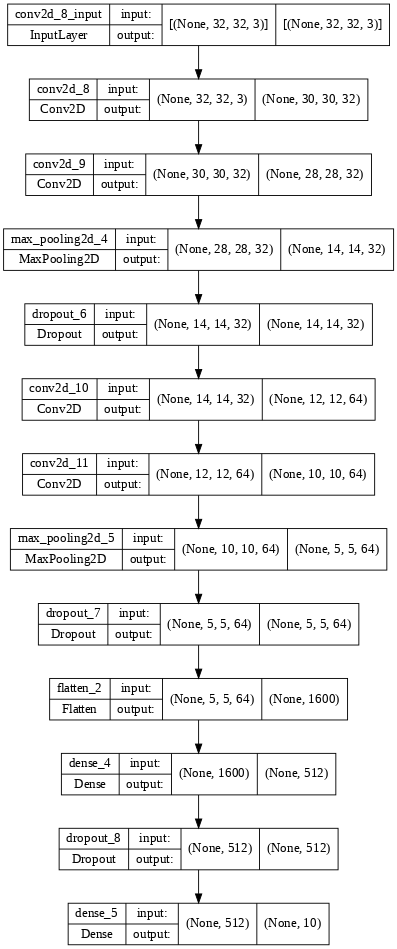

In [ ]:
# 모델 구조 설계
input_shape=(32,32,3)
n_kernals1=32
n_kernals2=64
n_hidden1=512
n_output=10

kernel_size=(3,3)
pool_size=(2,2)
strides=(1,1)

# Model hyperparameters
activation='relu'
kernel_initializer='glorot_uniform'
bias_initializer='zeros'
dropout_rate=[0.25,0.25,0.25]
l2_reg=0.0

# 모델 설계
cnn=Sequential()
cnn.add(Conv2D(n_kernals1,kernel_size,strides=strides,activation=activation,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,input_shape=input_shape))
cnn.add(Conv2D(n_kernals1,kernel_size,strides=strides,activation=activation,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer))
cnn.add(MaxPooling2D(pool_size=pool_size))
cnn.add(Dropout(dropout_rate[0]))
cnn.add(Conv2D(n_kernals2,kernel_size,strides=strides,activation=activation,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer))
cnn.add(Conv2D(n_kernals2,kernel_size,strides=strides,activation=activation,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer))
cnn.add(MaxPooling2D(pool_size=pool_size))
cnn.add(Dropout(dropout_rate[1]))
cnn.add(Flatten())
cnn.add(Dense(n_hidden1,activation=activation))
cnn.add(Dropout(dropout_rate[2]))
cnn.add(Dense(n_output,activation='softmax',kernel_regularizer=regularizers.l2(l2_reg)))

# 모델 확인
cnn.summary()

# SVG로 그리기
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model
%matplotlib inline
SVG(model_to_dot(cnn, show_shapes=True, dpi=65).create(prog='dot', format='svg'))  # SVG로 가시화
plot_model(cnn, to_file=dir+'cnn_cifar10.png', show_shapes=True, show_layer_names=True, dpi=65) # 파일 출력

모델 학습, 평가, 저장

In [ ]:
# Learning hyperparameters
batch_size=128
epochs=30
optimizer=Adam()

# 모델 학습
start=time.time()
cnn.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
hist=cnn.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_test,y_test),verbose=2)
end=time.time()
print("학습시간(초):", end-start)

# 정확률 평가(1)
res=cnn.evaluate(x_test,y_test,verbose=0)
print("정확률(%):",res[1]*100)

# 모델 저장
cnn.save(dir + "cnn_cifar10.h5")
print("Saved model to disk.")

Epoch 1/30
391/391 - 163s - loss: 1.5169 - accuracy: 0.4559 - val_loss: 1.2208 - val_accuracy: 0.5702 - 163s/epoch - 418ms/step
Epoch 2/30
391/391 - 166s - loss: 1.1088 - accuracy: 0.6136 - val_loss: 0.9514 - val_accuracy: 0.6710 - 166s/epoch - 425ms/step
Epoch 3/30


KeyboardInterrupt: ignored

모델 학습 그래프 그리기

In [ ]:
import matplotlib.pyplot as plt

# 정확률 그래프
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='best')
plt.grid()
plt.show()

# 손실 함수 그래프
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='best')
plt.grid()
plt.show()

테스트 결과 및 Confusion Matrix 그리기

In [ ]:
# 테스트 집합
res = cnn.predict(x_test)

# Confusion Matrix
conf=np.zeros((10,10))
for i in range(len(res)):
  conf[res[i].argmax()][y_test[i].argmax()]+=1
print(conf)

# 정확률 계산(2)
no_correct=0
for i in range(10):
  no_correct+=conf[i][i]
accuracy=no_correct/len(res)
print("정확률(%):",accuracy*100)

저장된 모델 불러오기 및 평가

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.python.keras.models import load_model

# 신경망 구조와 가중치를 저장하고 있는 파일을 읽어 옴
cnn2 = load_model(dir + "cnn_cifar10.h5")
cnn2.summary()

# CIFAR-10 데이터셋을 읽고 신경망에 입력할 형태로 변환
(x_train,y_train),(x_test,y_test) = cifar10.load_data()
x_train = x_train.astype(np.float32)/255.0
x_test = x_test.astype(np.float32)/255.0
y_train = tf.keras.utils.to_categorical(y_train,10)
y_test = tf.keras.utils.to_categorical(y_test,10)

res=cnn2.evaluate(x_test, y_test, verbose=0)
print("정확률(%):",res[1]*100)